<a href="https://colab.research.google.com/github/gaws15/AINotebooksVault/blob/main/image02_adl%C4%B1_dosyan%C4%B1n_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

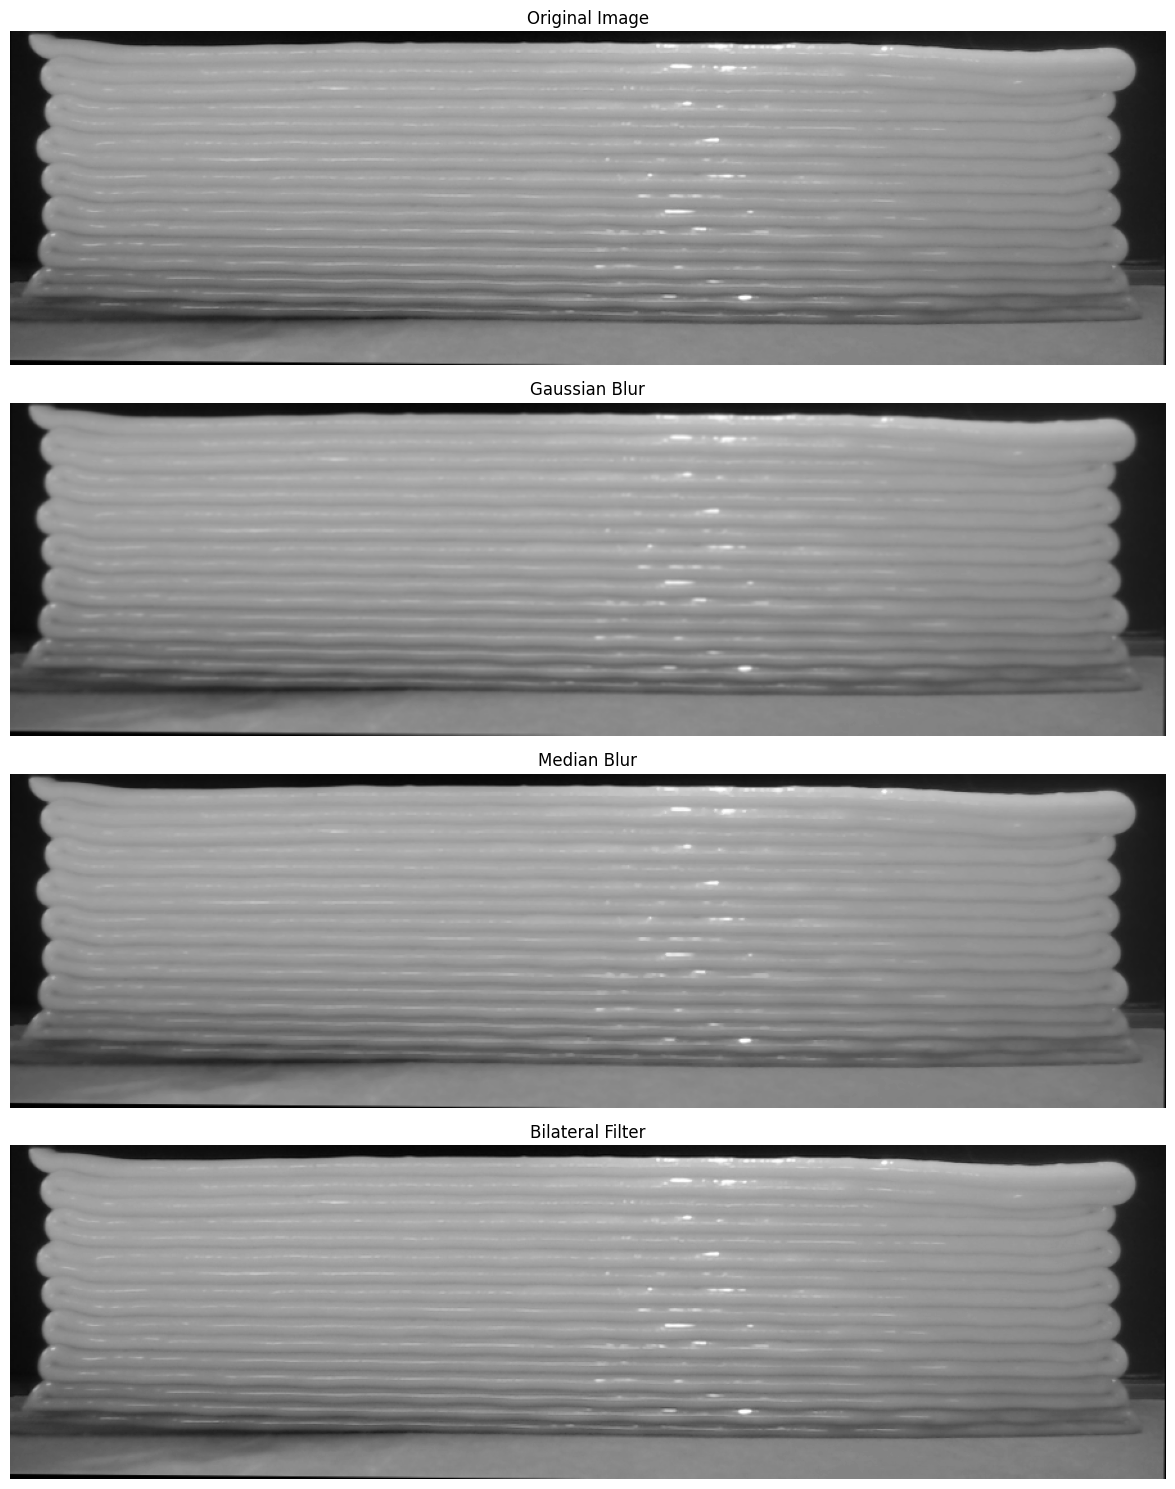

In [203]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from skimage.morphology import skeletonize

# Read the image
img = cv2.imread('/content/17.jpg', 0)  # 0 for grayscale
# Get the dimensions of the image
height, width = img.shape[:2]

# Calculate the new dimensions (half size)
new_height = height // 2
new_width = width // 2

# Resize the image
img = cv2.resize(img, (new_width, new_height), interpolation=cv2.INTER_AREA)

kernel_size=(3, 3)
  # Apply Gaussian Blur
gaussian_blur = cv2.GaussianBlur(img, kernel_size, 0)

    # Apply Median Blur
median_blur = cv2.medianBlur(img, kernel_size[0])  # Kernel size is a single value for medianBlur

    # Apply Bilateral Filter
bilateral_blur = cv2.bilateralFilter(img, 9, 75, 75)
normalize = cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

    # Plot the results
plt.figure(figsize=(60, 15))
plt.subplot(4, 1, 1)
plt.imshow(img, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(4, 1, 2)
plt.imshow(gaussian_blur, cmap='gray')
plt.title('Gaussian Blur')
plt.axis('off')

plt.subplot(4, 1, 3)
plt.imshow(median_blur, cmap='gray')
plt.title('Median Blur')
plt.axis('off')

plt.subplot(4, 1, 4)
plt.imshow(normalize, cmap='gray')
plt.title('Bilateral Filter')
plt.axis('off')

plt.tight_layout()
plt.show()

############## 4 farklı filtreleme operasyonu yapılıp içinden median blur ile devam edilmiştir.


histogram of the filters

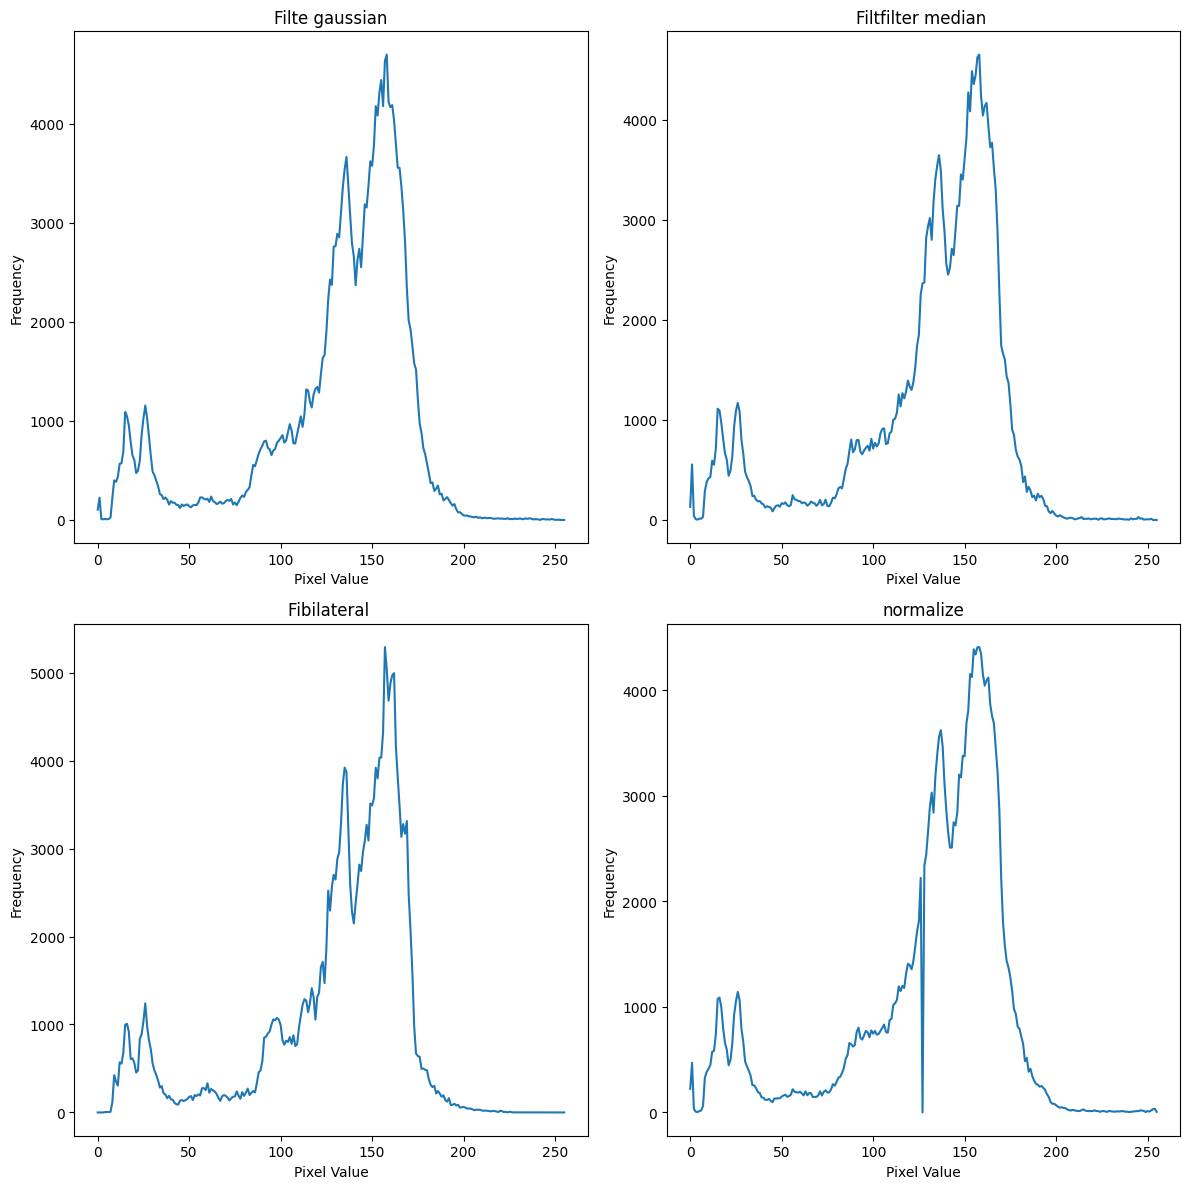

In [204]:
# Create a figure with subplots for each histogram
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()  # Flatten the array of axes for easier indexing

# Labels for each filter (adjust according to your filters)
filters = ['Filte gaussian', 'Filtfilter median ', 'Fibilateral ', 'normalize']

for i, (filtered_image, ax) in enumerate(zip([gaussian_blur,median_blur,bilateral_blur,normalize], axs)):
    # Compute histogram for each filtered image
    # We assume images are in uint8 format for 0-255 range; adjust if using float
    hist, bins = np.histogram(filtered_image.ravel(), bins=256, range=(0, 256))  # For uint8 images

    # Plot histogram
    ax.plot(bins[:-1], hist)
    ax.set_title(filters[i])
    ax.set_xlabel('Pixel Value')
    ax.set_ylabel('Frequency')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

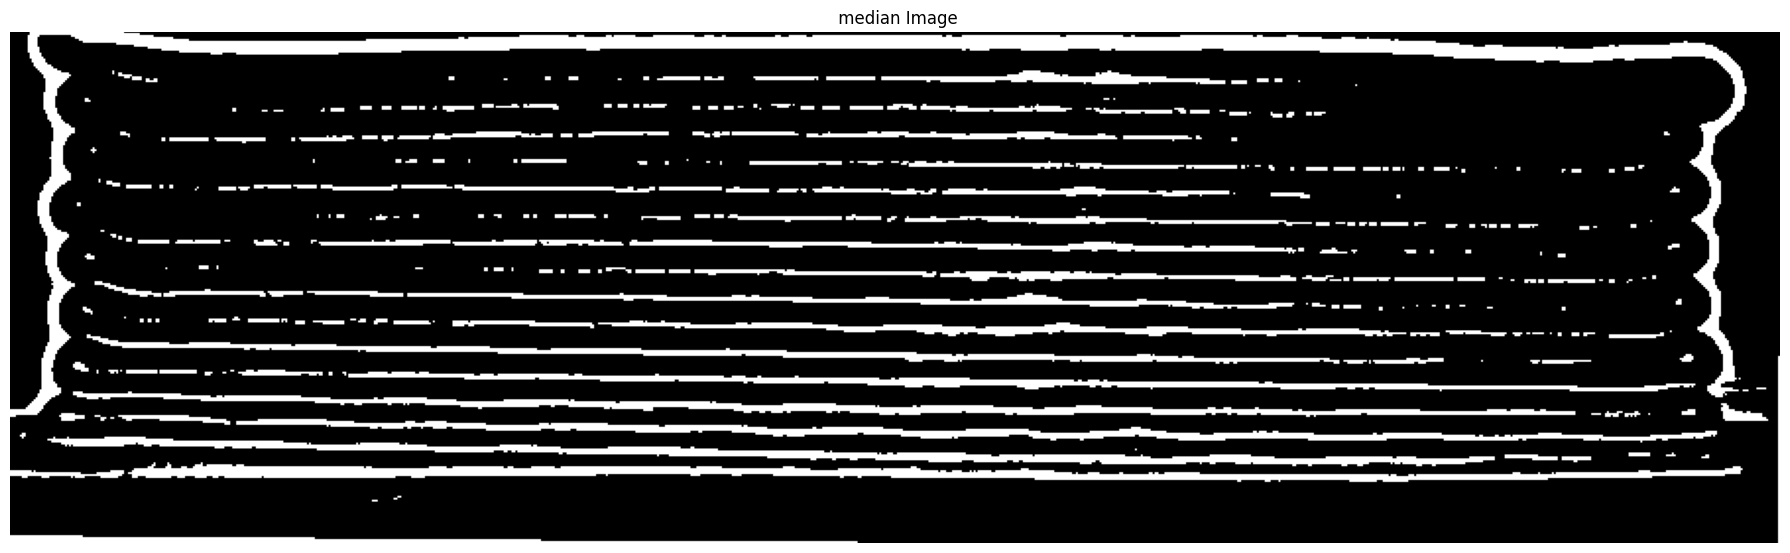

In [205]:
from skimage.morphology import skeletonize # This line likely already exists in the beginning of your notebook

# Apply adaptive thresholding on the blurred image
thresh1 = cv2.adaptiveThreshold(median_blur, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 25, 8)


# Adaptive Thresholding
thresh_gauss = cv2.adaptiveThreshold(gaussian_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11,4)
thresh_median = cv2.adaptiveThreshold(median_blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 11, 4)


# Subtract the thresholded images
subtracted_img = cv2.subtract(thresh_gauss, thresh_median)

# Logical deletion (keep only pixels where both images are white)
#thresh1 = cv2.bitwise_and(thresh_gauss, thresh_median)



# Display setup
fig, (ax1) = plt.subplots(1, 1, figsize=(18, 6))

ax1.imshow(thresh1, cmap='gray')
ax1.set_title(' median Image')
ax1.axis('off')


plt.tight_layout()
plt.show()

median masking

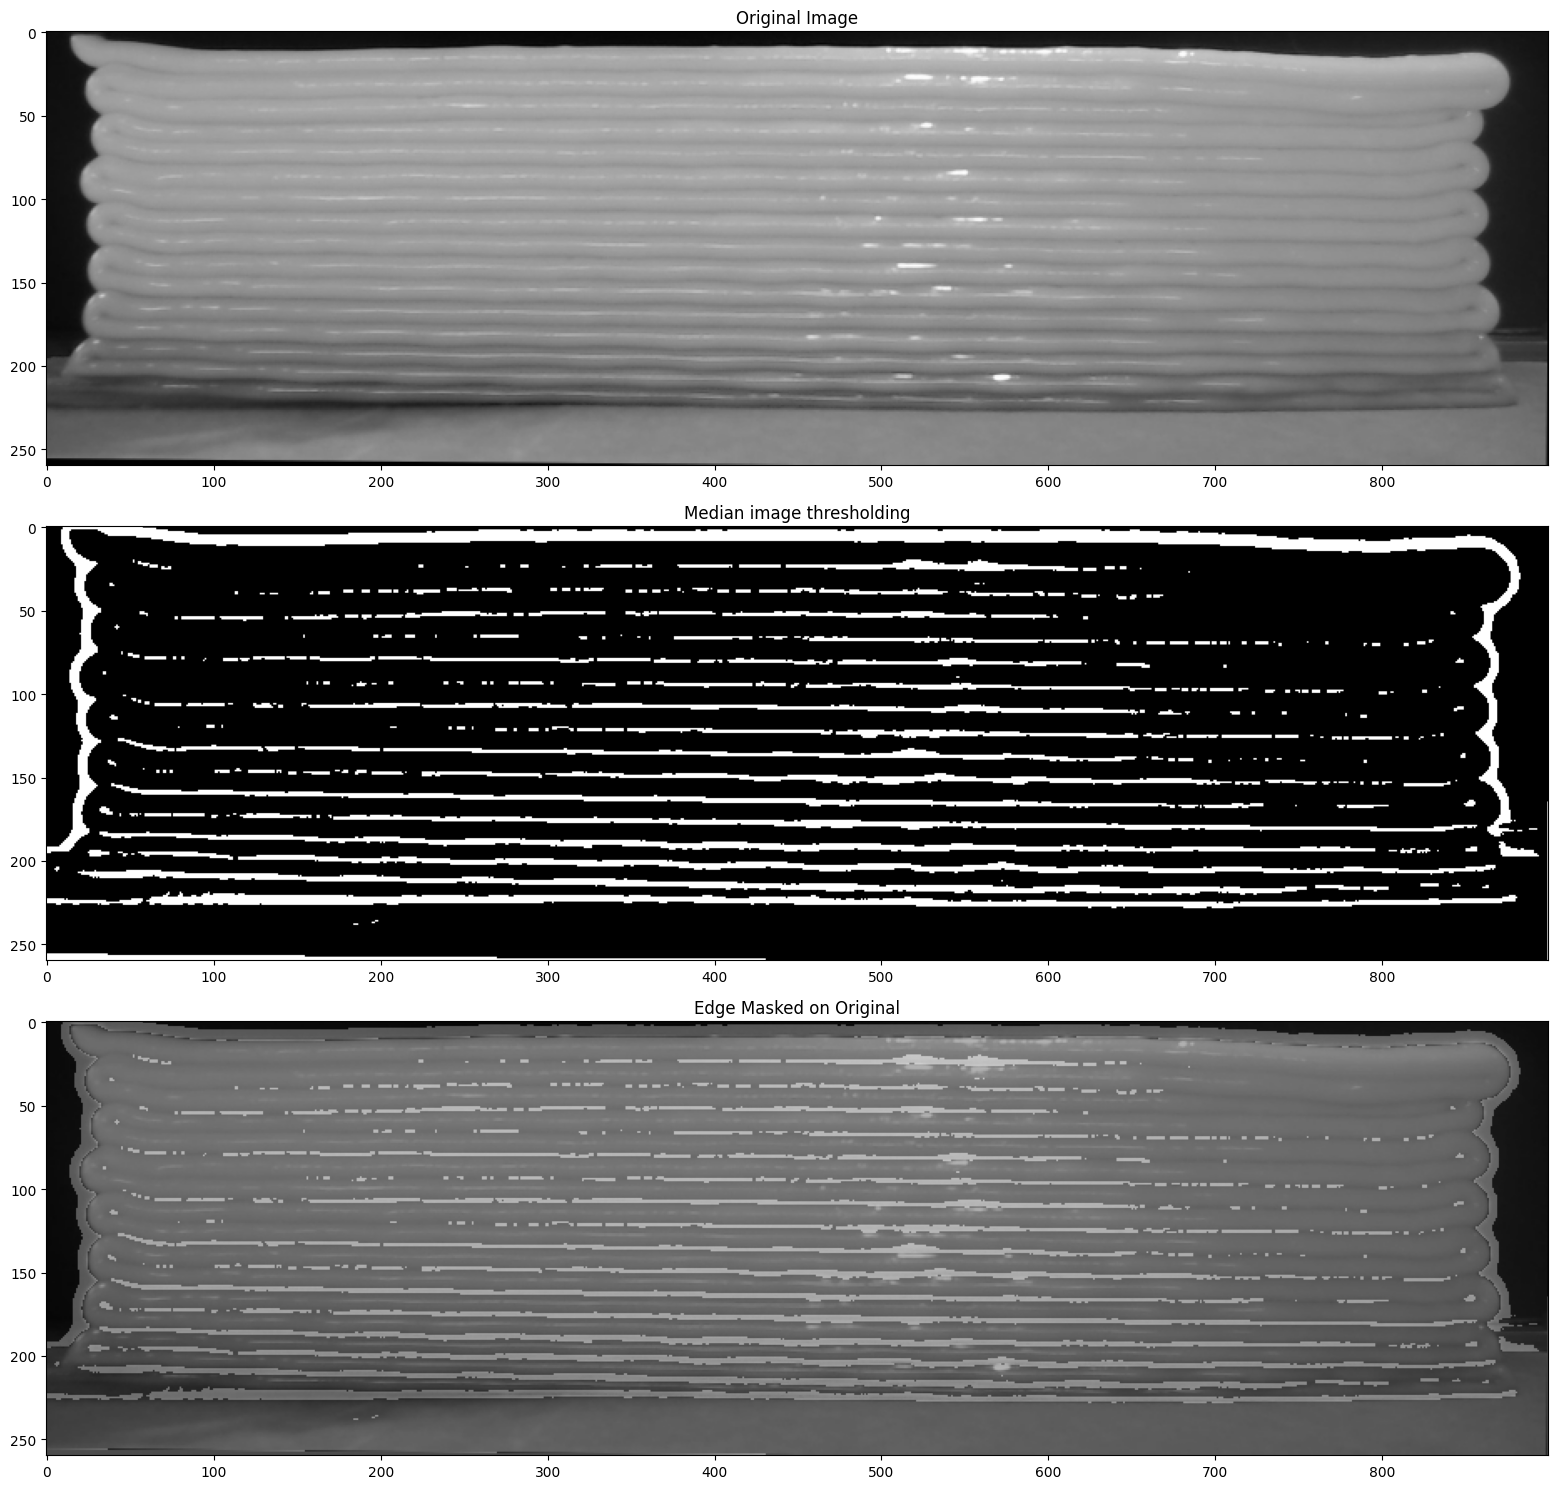

In [206]:

# Create a mask with the same shape and type as img (grayscale)
mask = np.zeros_like(img)
# Mark edges in white on the grayscale mask
mask[thresh1 != 0] = 255  # Use 255 for white in grayscale

# Overlay the mask on the original image using addWeighted
masked_image = cv2.addWeighted(img, 0.7, mask, 0.3, 0)

# Visualization
plt.figure(figsize=(60, 15))

plt.subplot(3, 1, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

plt.subplot(3, 1, 2)
plt.title('Median image thresholding')
plt.imshow(thresh1, cmap='gray')

plt.subplot(3, 1, 3)
plt.title('Edge Masked on Original')
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()


diğer thinning--skeletonizing methods

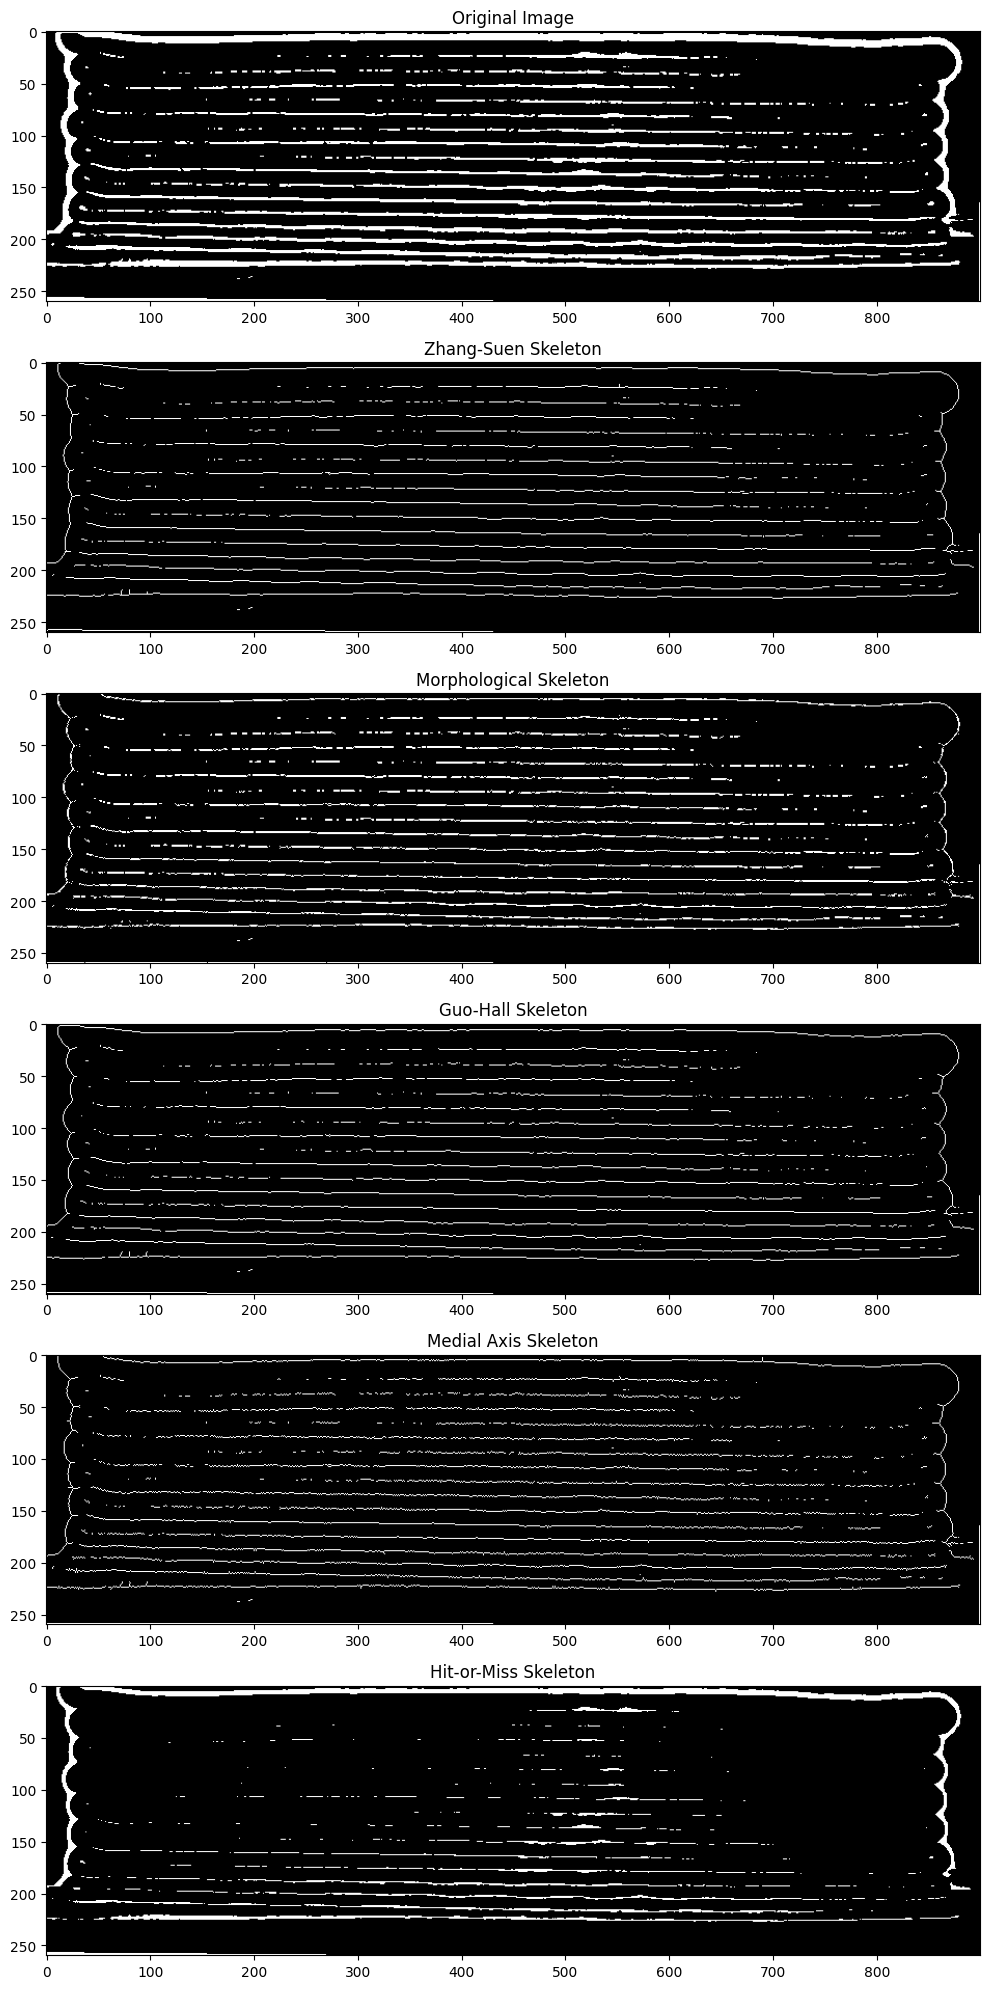

In [207]:
import cv2
import numpy as np
from skimage.morphology import skeletonize, thin, medial_axis
import matplotlib.pyplot as plt


# Convert to 0 or 1 for skimage
binary = thresh1 // 255

# 1. Zhang-Suen Skeletonization
zhang_suen = skeletonize(binary)
zhang_suen = (zhang_suen * 255).astype(np.uint8)

# 2. Morphological Skeleton (OpenCV)
def morphological_skeleton(img):
    size = np.size(img)
    skeleton = np.zeros(img.shape, np.uint8)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))

    while True:
        eroded = cv2.erode(img, kernel)
        temp = cv2.dilate(eroded, kernel)
        temp = cv2.subtract(img, temp)
        skeleton = cv2.bitwise_or(skeleton, temp)
        img = eroded.copy()
        if cv2.countNonZero(img) == 0:
            break
    return skeleton

morph_skel = morphological_skeleton(binary * 255)

# 3. Guo-Hall Thinning

thin_guo_hall = thin(thresh1)  # Remove max_iter argument
thin_guo_hall = (thin_guo_hall * 255).astype(np.uint8)

# 4. Medial Axis Skeletonization
medial_skel, distance = medial_axis(binary, return_distance=True)
medial_skel = (medial_skel * 255).astype(np.uint8)

# 5. Hit-or-Miss Skeletonization
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
hit_miss_skel = cv2.morphologyEx(binary * 255, cv2.MORPH_HITMISS, kernel)

# Visualization
plt.figure(figsize=(100, 20))

plt.subplot(6, 1, 1)
plt.title('Original Image')
plt.imshow(binary * 255, cmap='gray')

plt.subplot(6, 1, 2)
plt.title('Zhang-Suen Skeleton')
plt.imshow(zhang_suen, cmap='gray')

plt.subplot(6, 1, 3)
plt.title('Morphological Skeleton')
plt.imshow(morph_skel, cmap='gray')

plt.subplot(6, 1, 4)
plt.title('Guo-Hall Skeleton')
plt.imshow(thin_guo_hall, cmap='gray')

plt.subplot(6, 1, 5)
plt.title('Medial Axis Skeleton')
plt.imshow(medial_skel, cmap='gray')

plt.subplot(6, 1, 6)
plt.title('Hit-or-Miss Skeleton')
plt.imshow(hit_miss_skel, cmap='gray')

plt.tight_layout()
plt.show()


346
[[     0      0    900    260 222322]
 [     1      0    879    194   1305]
 [    52     20      1      2      2]
 ...
 [   195    236      4      2      4]
 [   184    238      3      1      3]
 [     1    257    430      3    430]]


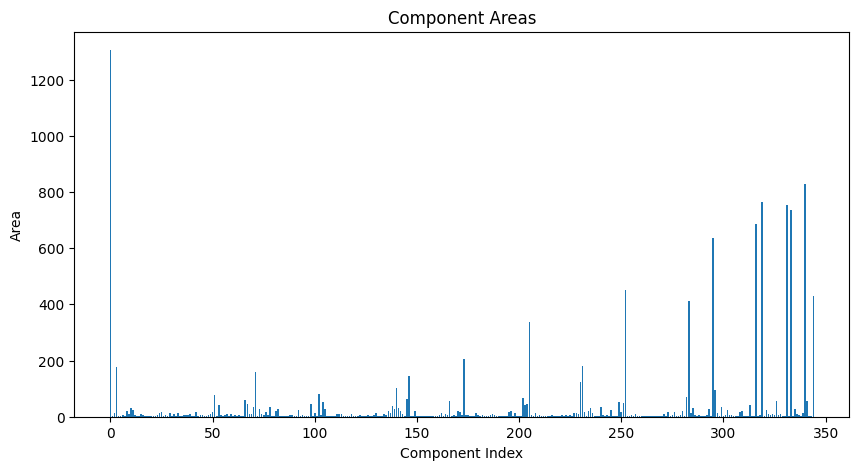

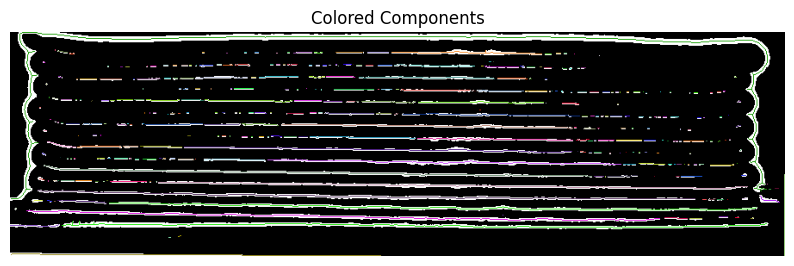

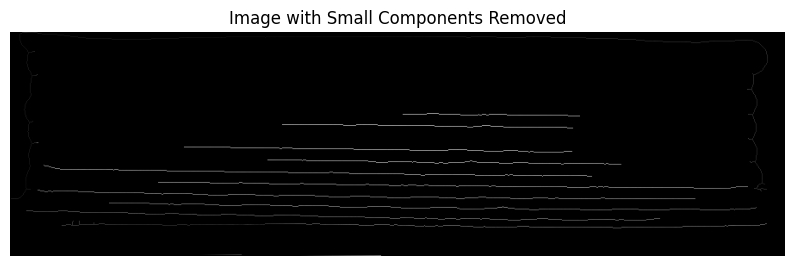

True

In [208]:
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(zhang_suen, connectivity=8)
print(num_labels)
print(stats)
# Create a color image for visualization
color_image = cv2.cvtColor(thresh1, cv2.COLOR_GRAY2BGR)
# Define colors for each component (excluding background)
colors = np.random.randint(0, 255, size=(num_labels, 3), dtype=np.uint8)

# Color each component differently
for label in range(1, num_labels):  # label 0 is background
    color_image[labels == label] = colors[label]

# Plot areas of components
areas = stats[1:, cv2.CC_STAT_AREA]  # Exclude background
plt.figure(figsize=(10, 5))
plt.bar(range(len(areas)), areas)
plt.title('Component Areas')
plt.xlabel('Component Index')
plt.ylabel('Area')
plt.show()

# Display the colored components
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(color_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for matplotlib
plt.title('Colored Components')
plt.axis('off')
plt.show()

# Define a size threshold for what you consider 'small'
size_threshold = 200  # Adjust based on your image size and needs

# Create a mask where only large components will be kept
mask = np.zeros(thresh1.shape, dtype="uint8")

for i in range(1, num_labels):  # Start from 1 because 0 is the background
    if stats[i, cv2.CC_STAT_AREA] >= size_threshold:
        mask[labels == i] = 255

# Apply the mask to the original image to remove small components
result_image = cv2.bitwise_and(img, img, mask=mask)

# Convert result back to color for visualization if it's grayscale
if len(result_image.shape) == 2:
    result_image = cv2.cvtColor(result_image, cv2.COLOR_GRAY2BGR)

# Display or save the result
plt.figure(figsize=(10, 10))
plt.imshow(result_image, cmap='gray' if len(result_image.shape) == 2 else None)
plt.title('Image with Small Components Removed')
plt.axis('off')
plt.show()

cv2.imwrite('cleaned_image.jpg', result_image)

In [209]:
# sampling and calculation -zhang-Suen Skeletonisation

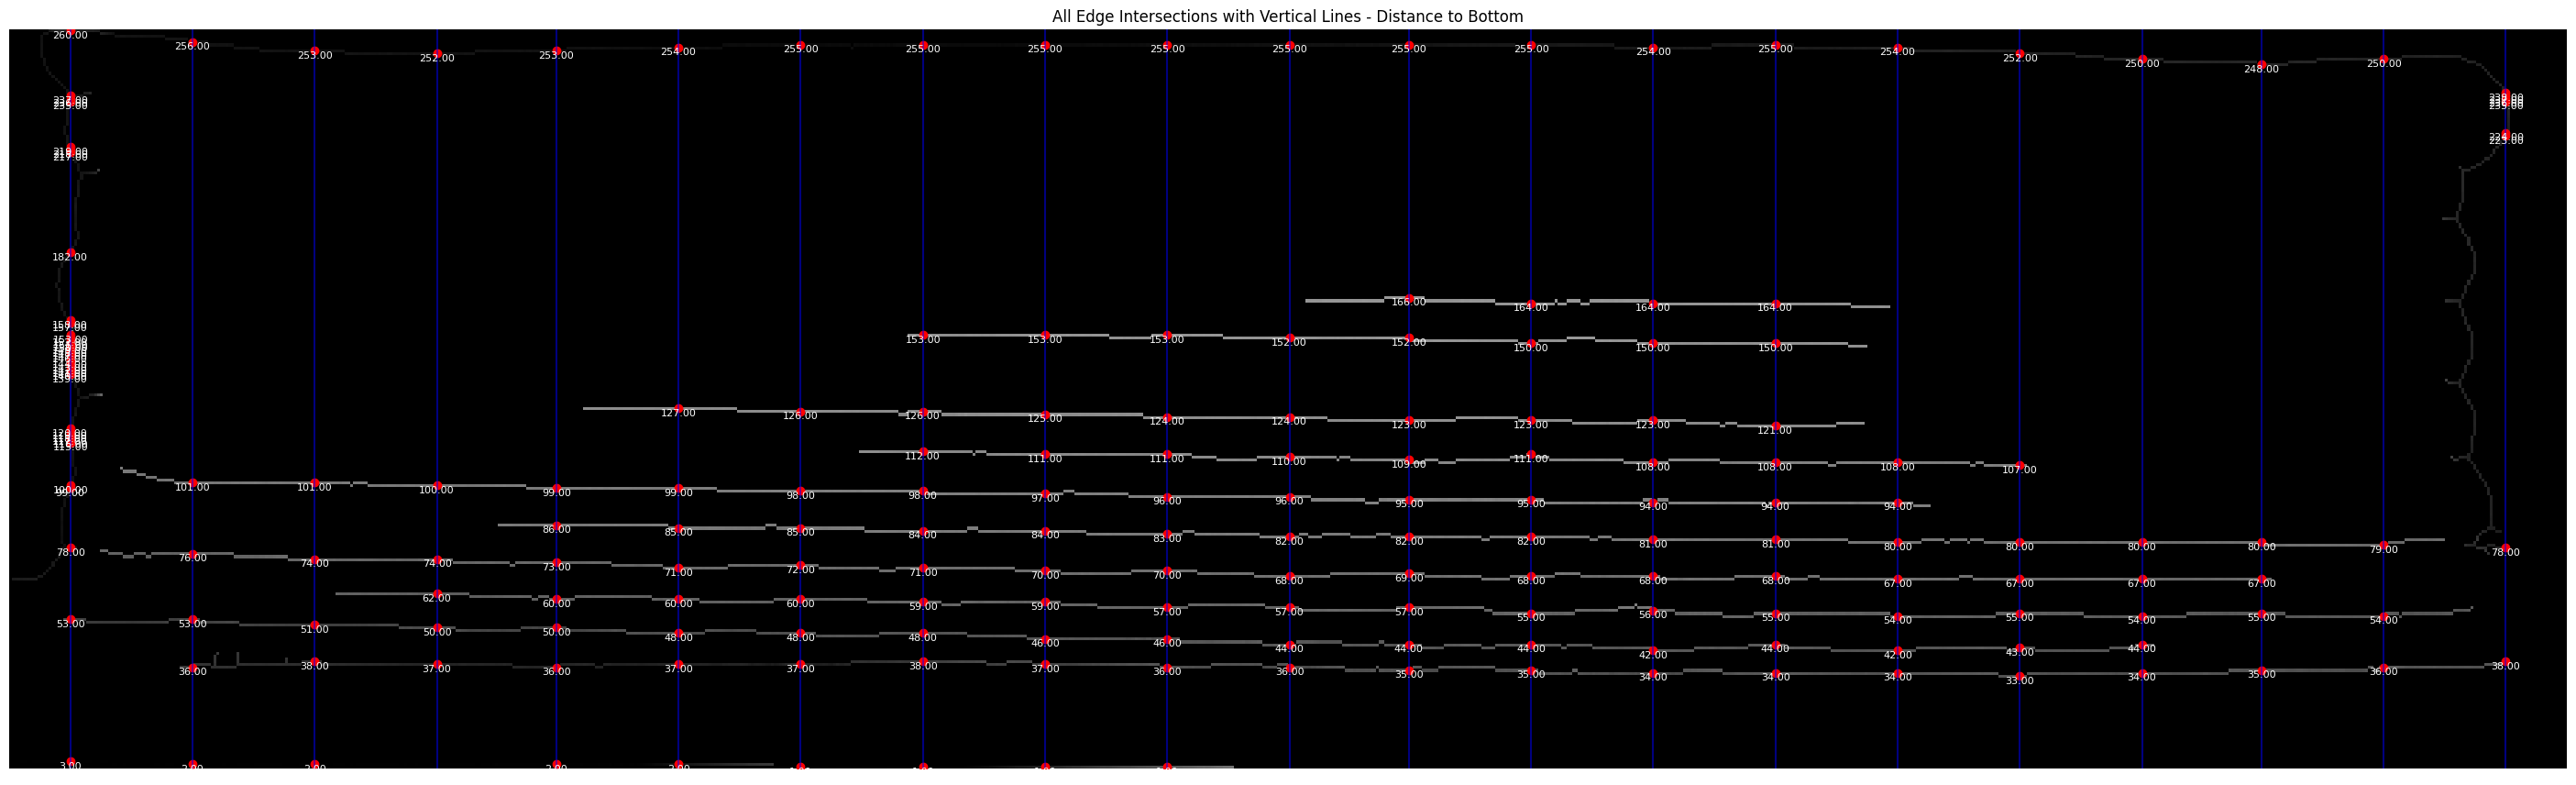

In [210]:
# 1. Zhang-Suen Skeletonization
# Divide vertically into 50 segments
# Image dimensions

# Check if the image has multiple channels
if len(result_image.shape) == 3:  # If it's a color image (e.g., RGB)
    height, width, _ = result_image.shape  # Ignore the channel dimension
else:  # If it's a grayscale image
    height, width = result_image.shape

divisions = 21
all_points = []

for i in range(divisions):
    x = int((i + 0.5) * width / divisions)  # +0.5 to center the line in each division
    local_points = []

    for y in range(height):
        # Check if any channel value is greater than 0
        if (result_image[y, x] > 0).any():  # Assuming edges are represented by positive values in any channel
            local_points.append((x, y))

    # If no edges found, add one point at the bottom
    if not local_points:
        local_points.append((x, height - 1))

    all_points.extend(local_points)

# Visualization
plt.figure(figsize=(36, 12))
plt.imshow(result_image, cmap='gray')

# Plot all points
for x, y in all_points:
    plt.plot(x, y, 'ro')  # red dot for each intersection point

# Draw vertical lines for each division
for i in range(divisions):
    x = int((i + 0.5) * width / divisions)
    plt.axvline(x, color='b', alpha=0.5)  # Blue vertical lines

# Measure and annotate distance from each point to the bottom
for x, y in all_points:
    distance = height - y  # Measure from the point to the bottom
    plt.text(x, y, f'{distance:.2f}', color='white', fontsize=8, ha='center', va='top')  # va='top' to position text above point

plt.title('All Edge Intersections with Vertical Lines - Distance to Bottom')
plt.axis('off')
plt.savefig('017.png', bbox_inches='tight')

plt.show()



masking operation ans see the line on the original image   ---verification

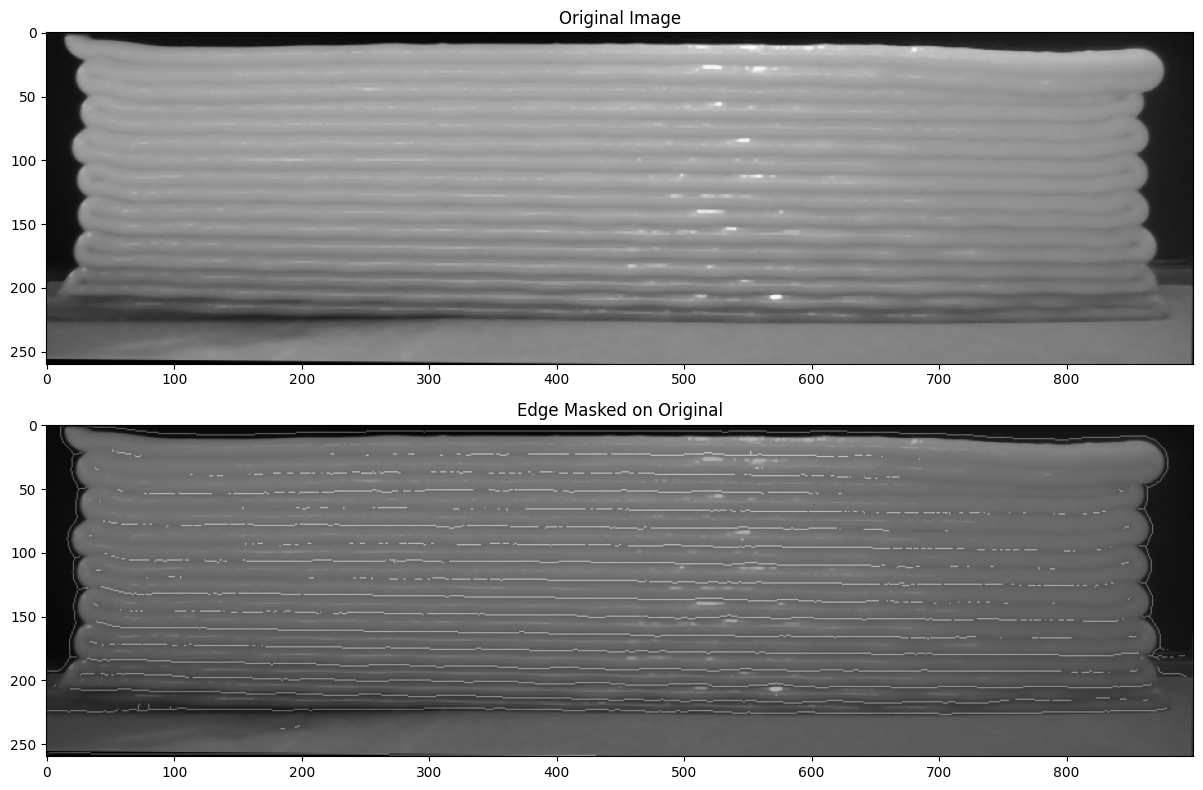

In [211]:
# Create mask from skeleton with 3 channels
mask = np.zeros_like(img, dtype=np.uint8)  # Ensure dtype is uint8 for color image

# Convert the mask to BGR format
mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)  # Convert to 3 channels

# Now you can assign the color to the mask (still grayscale):
mask[zhang_suen == 255] = 255  # Mark edges in white (or any grayscale value)

# Overlay the mask on the original image
# Since both are grayscale now, addWeighted should work
masked_image = cv2.addWeighted(img, 0.7, mask[:,:,0], 0.3, 0) #Use only one channel from mask

# Now you can assign the color to the mask:
mask[zhang_suen == 255] = [0, 255, 0]  # Mark edges in green


# Visualization
plt.figure(figsize=(20, 8))

plt.subplot(2, 1, 1)
plt.title('Original Image')
plt.imshow(cv2.cvtColor(median_blur, cv2.COLOR_BGR2RGB))

plt.subplot(2, 1, 2)
plt.title('Edge Masked on Original')
plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))

plt.tight_layout()
plt.show()

Masking Operation